In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import interpolate

%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 5) # (w, h)

def rmse(arr_1, arr_2, axis=None):
    mask = np.logical_and(~np.isnan(arr_1), ~np.isnan(arr_2))
    return np.sqrt(np.mean(np.square(arr_1[mask] - arr_2[mask]), axis=axis))

# Simplified Example

In [5]:
# Flight lines are stacked column-wise:
flight_lines = np.array([[1, 0, 1, 0, 1, 0],
                         [1, 0, 1, 0, 1, 0],
                         [1, 0, 1, 0, 1, 0],
                         [1, 0, 1, 0, 1, 0],
                         [1, 0, 1, 0, 1, 0]])

lats = np.array([[0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [2, 2, 2, 2, 2, 2],
                 [3, 3, 3, 3, 3, 3],
                 [4, 4, 4, 4, 4, 4]])
    
lons = np.array([[0, 1, 2, 3, 4, 5],
                 [0, 1, 2, 3, 4, 5],
                 [0, 1, 2, 3, 4, 5],
                 [0, 1, 2, 3, 4, 5],
                 [0, 1, 2, 3, 4, 5]])

num_ptls = 3
ptl_locs = np.array([0, 2, 4])

percent_thresh = 0.85

In [6]:
if ptl_locs is None:
    ptl_locs = np.linspace(0, flight_lines.shape[0] - 1, num_ptls)

print('ptl_locs')
print(ptl_locs)

ptl_locs
[0 2 4]


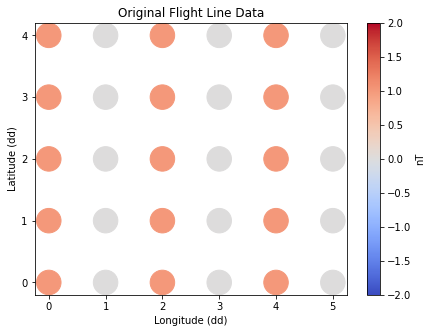

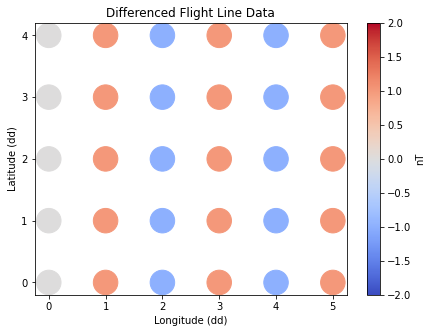

In [7]:
fl_diff = np.zeros(flight_lines.shape)
fl_diff[:, 1:] = (flight_lines - np.roll(flight_lines, -1))[:, :-1]

plt.figure()
plt.title('Original Flight Line Data')
plt.scatter(lons, lats, s=600, c=flight_lines, cmap=cm.coolwarm)
plt.xticks(np.unique(lons))
plt.yticks(np.unique(lats))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

plt.figure()
plt.title('Differenced Flight Line Data')
plt.scatter(lons, lats, s=600, c=fl_diff, cmap=cm.coolwarm)
plt.xticks(np.unique(lons))
plt.yticks(np.unique(lats))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

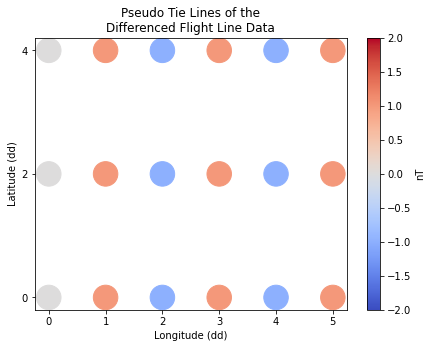

In [8]:
ptls = fl_diff[ptl_locs, :]

ptl_lats = lats[ptl_locs, :]
ptl_lons = lons[ptl_locs, :]

plt.figure()
plt.title('Pseudo Tie Lines of the\nDifferenced Flight Line Data')
plt.scatter(ptl_lons, ptl_lats, s=600, c=ptls, cmap=cm.coolwarm)
plt.xticks(np.unique(ptl_lons))
plt.yticks(np.unique(ptl_lats))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

In [9]:
diff_cov = np.cov(ptls)

print('Pseudo Tie Line Covariance Matrix')
print(diff_cov)

Pseudo Tie Line Covariance Matrix
[[0.96666667 0.96666667 0.96666667]
 [0.96666667 0.96666667 0.96666667]
 [0.96666667 0.96666667 0.96666667]]


In [10]:
R, eigvals, _ = np.linalg.svd(diff_cov)

print('Rotation Matrix')
print(R)
print('Eigenvalues of Pseudo Tie Line Covariance Matrix')
print(eigvals)
print('SVD Check')
check = R @ np.diag(eigvals) @ R.T
print(check)
if (check == diff_cov).all():
    print('Passed')
else:
    print('Failed')

Rotation Matrix
[[-5.77350269e-01  8.16496581e-01 -4.42903565e-17]
 [-5.77350269e-01 -4.08248290e-01 -7.07106781e-01]
 [-5.77350269e-01 -4.08248290e-01  7.07106781e-01]]
Eigenvalues of Pseudo Tie Line Covariance Matrix
[2.90000000e+00 1.28197512e-16 2.73691106e-48]
SVD Check
[[0.96666667 0.96666667 0.96666667]
 [0.96666667 0.96666667 0.96666667]
 [0.96666667 0.96666667 0.96666667]]
Failed


In [11]:
val_cum_sum      = np.cumsum(np.real(np.abs(eigvals)) / np.sum(np.real(np.abs(eigvals))))
last_comp_idx    = np.where(val_cum_sum >= percent_thresh)[0].min()

components        = R.T @ ptls
reconstruct_comps = components[:last_comp_idx + 1, :]

print('All Components')
print(components)
print('Number of Components to use for Reconstruction')
print(last_comp_idx + 1)
print('Components used for Reconstruction')
print(reconstruct_comps)

All Components
[[ 0.00000000e+00 -1.73205081e+00  1.73205081e+00 -1.73205081e+00
   1.73205081e+00 -1.73205081e+00]
 [ 0.00000000e+00  4.44089210e-16 -4.44089210e-16  4.44089210e-16
  -4.44089210e-16  4.44089210e-16]
 [ 0.00000000e+00  1.11022302e-16 -1.11022302e-16  1.11022302e-16
  -1.11022302e-16  1.11022302e-16]]
Number of Components to use for Reconstruction
1
Components used for Reconstruction
[[ 0.         -1.73205081  1.73205081 -1.73205081  1.73205081 -1.73205081]]


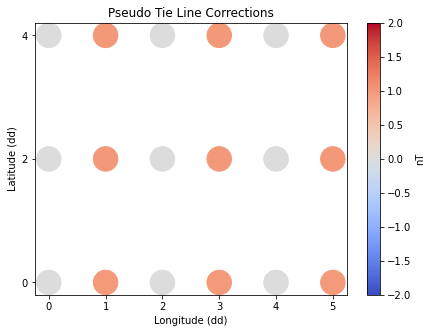

In [12]:
ptl_corrs = R[:, :last_comp_idx + 1] @ reconstruct_comps
ptl_corrs = np.cumsum(ptl_corrs, axis=1)

plt.figure()
plt.title('Pseudo Tie Line Corrections')
plt.scatter(ptl_lons, ptl_lats, s=600, c=ptl_corrs, cmap=cm.coolwarm)
plt.xticks(np.unique(ptl_lons))
plt.yticks(np.unique(ptl_lats))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

In [13]:
ptl_lats = lats[ptl_locs, :]
ptl_lons = lons[ptl_locs, :]
    
points   = list(zip(ptl_lons.flatten(), ptl_lats.flatten()))
values   = ptl_corrs.flatten()
fl_corrs = interpolate.griddata(points, values, (lons, lats), method='linear')

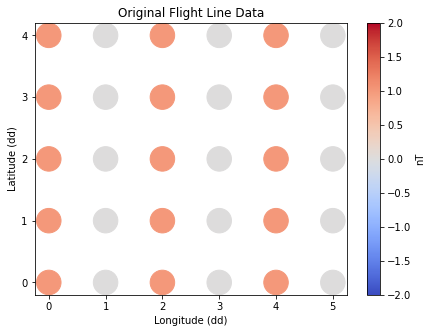

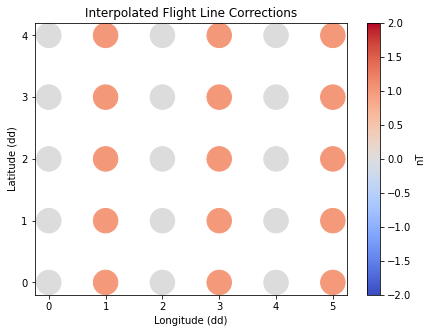

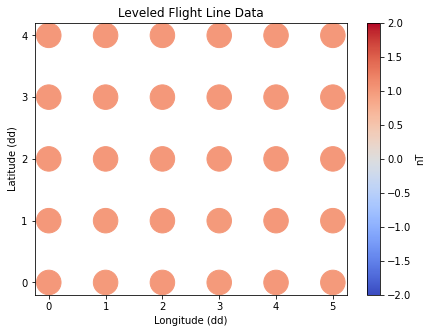

In [14]:
lvl_fls = flight_lines + fl_corrs

plt.figure()
plt.title('Original Flight Line Data')
plt.scatter(lons, lats, s=600, c=flight_lines, cmap=cm.coolwarm)
plt.xticks(np.unique(lons))
plt.yticks(np.unique(lats))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

plt.figure()
plt.title('Interpolated Flight Line Corrections')
plt.scatter(lons, lats, s=600, c=fl_corrs, cmap=cm.coolwarm)
plt.xticks(np.unique(lons))
plt.yticks(np.unique(lats))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

plt.figure()
plt.title('Leveled Flight Line Data')
plt.scatter(lons, lats, s=600, c=lvl_fls, cmap=cm.coolwarm)
plt.xticks(np.unique(lons))
plt.yticks(np.unique(lats))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

# Example with Simulated Survey Data

## Setup:

In [15]:
import sys
from os import getcwd
from os.path import dirname, join

import pandas as pd
import scipy.linalg as la
from matplotlib import cm

import MAMMAL.Diurnal as Diurnal
from ppigrf import igrf
from MAMMAL.Utils import coordinateUtils as cu


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)


REF_FNAME    = join(getcwd(), 'data', 'ref_2019_9_12_0.csv')
SURVEY_FNAME = join(getcwd(), 'data', 'survey_2019_9_12_0.csv')


ref_df    = pd.read_csv(REF_FNAME, parse_dates=['datetime'])
survey_df = pd.read_csv(SURVEY_FNAME, parse_dates=['datetime'])

## Save Truth Data

In [16]:
timestamps = survey_df.loc[survey_df.LINE_TYPE == 1, 'epoch_sec']
lats       = survey_df.loc[survey_df.LINE_TYPE == 1, 'LAT']
lons       = survey_df.loc[survey_df.LINE_TYPE == 1, 'LONG']
heights    = survey_df.loc[survey_df.LINE_TYPE == 1, 'ALT']

# Find diurnal/space weather effects
_, ref_scalar = Diurnal.interp_reference_df(df            = ref_df,
                                            timestamps    = timestamps,
                                            survey_lon    = None,
                                            ref_scale     = 1,
                                            ref_offset    = 0,
                                            subtract_core = True)

# Find Earth's Core field
Be, Bn, Bu = igrf(lons,
                  lats,
                  heights / 1000,
                  survey_df.datetime[0])

IGRF = np.hstack((Bn.squeeze()[:, np.newaxis],
                  Be.squeeze()[:, np.newaxis],
                 -Bu.squeeze()[:, np.newaxis]))
IGRF_F = la.norm(IGRF, axis=1)

# Remove non-anomaly components
survey_df.loc[survey_df.LINE_TYPE == 1, 'F'] -= ref_scalar
survey_df.loc[survey_df.LINE_TYPE == 1, 'F'] -= IGRF_F

# Save truth
truth_fl_scalar = survey_df.loc[survey_df.LINE_TYPE == 1, 'F']

## "Unlevel" the Flight Lines:

In [17]:
unique_fl_nums = np.unique(survey_df.LINE[survey_df.LINE_TYPE == 1])
every_other_unique_fl_num = unique_fl_nums[1::2]

# Add a 10nT offset every other flight line
for line in every_other_unique_fl_num:
    survey_df.loc[np.logical_and(survey_df.LINE == line,
                                 survey_df.LINE_TYPE == 1), 'F'] += 10

## Sample Flight Lines at Pseudo Tie Line Locations Before Leveling

In [18]:
avg_line_azs   = np.zeros(len(unique_fl_nums))
avg_line_lens  = np.zeros(len(unique_fl_nums))
avg_samp_dists = np.zeros(len(unique_fl_nums))

for i, line in enumerate(unique_fl_nums):
    mask = np.where(survey_df.LINE == line)[0]
    
    lats = np.array(survey_df.LAT[mask])
    lons = np.array(survey_df.LONG[mask])
    azs  = np.array(survey_df.AZIMUTH[mask])[1:-1] # TODO: use coordinate to coordinate azimuth instead
    
    avg_line_azs[i]   = azs.mean()
    avg_line_lens[i]  = cu.coord_dist(lats[0], lons[0], lats[-1], lons[-1])
    avg_samp_dists[i] = avg_line_lens[i] / len(lats)

avg_line_az   = (avg_line_azs % 180).mean() # Keep flight line azimuth between 0 to 180 degrees for simplicity
avg_line_len  = avg_line_lens.mean()

ptl_locs = np.array([0.0, 1.0])
ptl_locs = (ptl_locs * avg_line_len) - (avg_line_len / 2.0)

sample_shape = (len(unique_fl_nums), len(ptl_locs))

sampled_fl_scalar = np.zeros(sample_shape)
sampled_fl_lats   = np.zeros(sample_shape)
sampled_fl_lons   = np.zeros(sample_shape)

for i, loc in enumerate(ptl_locs):
    for j, line in enumerate(unique_fl_nums):
        mask = np.where(survey_df.LINE == line)[0]
        
        scalar = np.array(survey_df.F[mask])
        lats   = np.array(survey_df.LAT[mask])
        lons   = np.array(survey_df.LONG[mask])
        
        center_lat = (lats.max() + lats.min()) / 2
        center_lon = (lons.max() + lons.min()) / 2
        
        dist = loc
        az   = avg_line_az
        
        if dist < 0:
            dist *= -1
            az   += 180
        
        sampled_lat, sampled_lon = cu.coord_coord(center_lat, center_lon, dist, az)
        
        rbfi_scalar = interpolate.Rbf(lons,
                                      lats,
                                      scalar,
                                      function='linear',
                                      smooth=0)
    
        interp_scalar = rbfi_scalar(sampled_lon, sampled_lat)
        
        sampled_fl_scalar[j, i] = interp_scalar
        sampled_fl_lats[j, i]   = sampled_lat
        sampled_fl_lons[j, i]   = sampled_lon

## Level the Flight Lines:

1.2118885707540166 nT


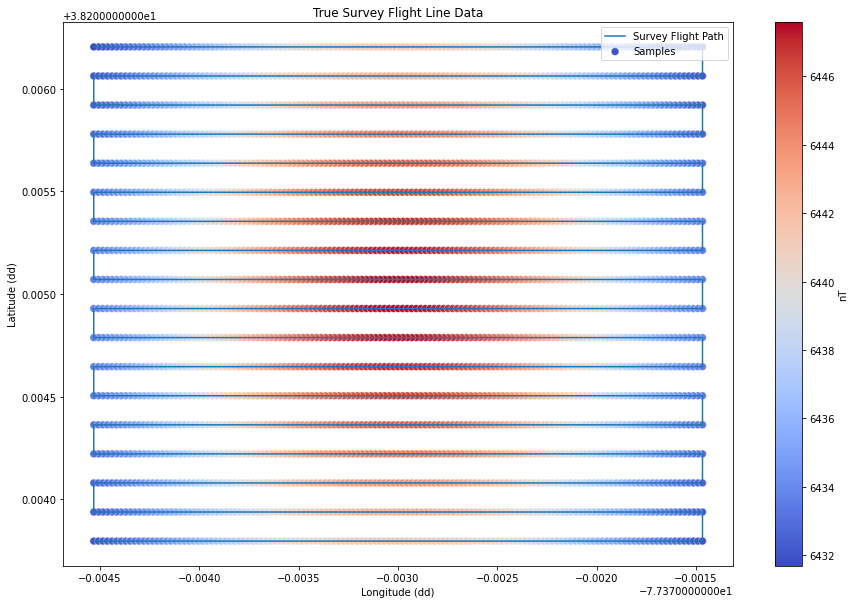

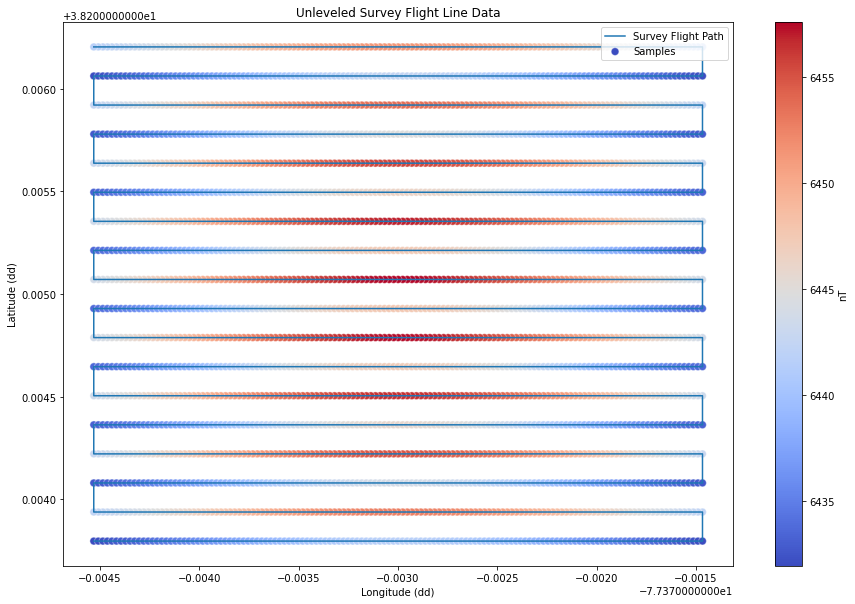

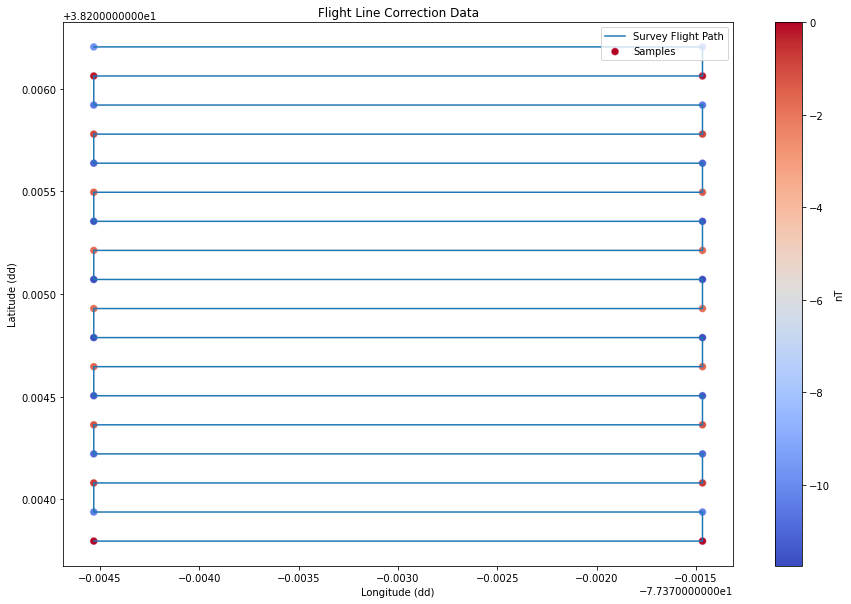

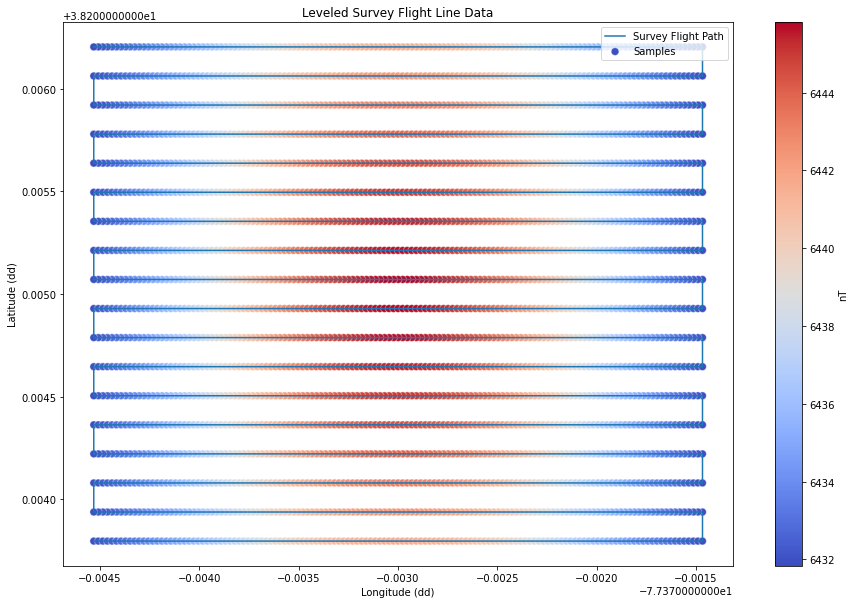

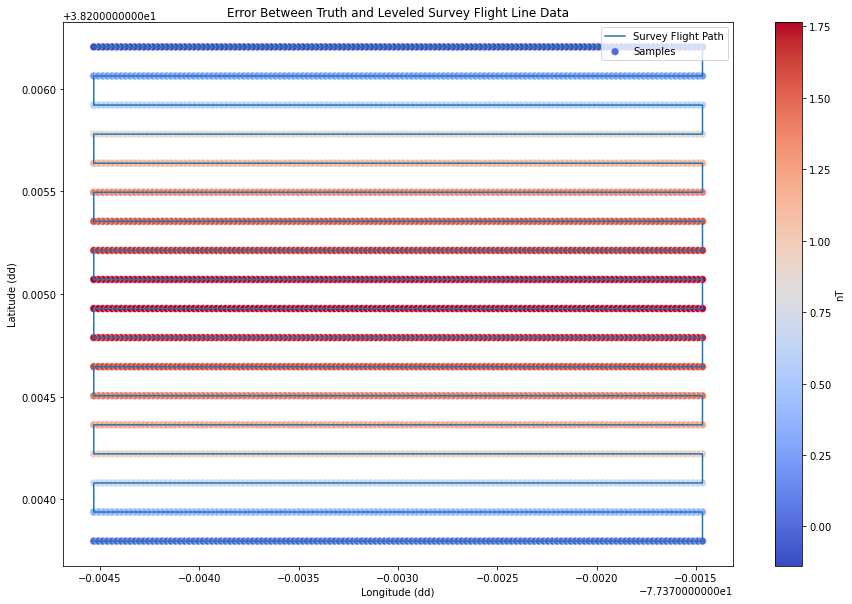

In [19]:
# Set cumulative contribution rate percent threshold
percent_thresh = 0.85

# Find the approximate error between adjacent flight lines
fl_diff = np.zeros(sample_shape).T
fl_diff[:, 1:] = (sampled_fl_scalar.T - np.roll(sampled_fl_scalar.T, -1))[:, :-1]

# Create pseudo tie-lines of the flight line difference data
ptls = fl_diff

# Find pseudo tie-line covariance matrix
diff_cov = np.cov(ptls)

# Find SVD of pseudo tie-line covariance matrix
R, eigvals, _ = np.linalg.svd(diff_cov)

# Find minimum required components for PCA reconstruction
val_cum_sum       = np.cumsum(np.real(np.abs(eigvals)) / np.sum(np.real(np.abs(eigvals))))
last_comp_idx     = np.where(val_cum_sum >= percent_thresh)[0].min()
components        = R.T @ ptls
reconstruct_comps = components[:last_comp_idx + 1, :]

# Calculate pseudo tie-line correction terms
ptl_corrs = R[:, :last_comp_idx + 1] @ reconstruct_comps
ptl_corrs = np.cumsum(ptl_corrs, axis=1)

# Interpolate pseudo tie-line correction terms and evaluate flight
# line corrections at all flight line sample locations
ptl_lats = sampled_fl_lats
ptl_lons = sampled_fl_lons

num_fl_samps     = (survey_df.LINE_TYPE == 1).sum()
interp_ptl_corrs = np.zeros(num_fl_samps)

start = 0

for i, fl_num in enumerate(unique_fl_nums):
    num_samps = (survey_df.LINE == fl_num).sum()
    
    fl_scalar = survey_df.loc[survey_df.LINE == fl_num, 'F']
    fl_lats   = survey_df.loc[survey_df.LINE == fl_num, 'LAT']
    fl_lons   = survey_df.loc[survey_df.LINE == fl_num, 'LONG']
    
    rbf = interpolate.Rbf(ptl_lons[i, :], ptl_lats[i, :], ptl_corrs.T[i, :], function='linear')
    interp_ptl_corrs[start:start + num_samps] = rbf(fl_lons, fl_lats)
    
    start = start + num_samps

# Apply interpolated corrections to flight line data
fl_scalar = survey_df.loc[survey_df.LINE_TYPE == 1, 'F']
fl_lats   = survey_df.loc[survey_df.LINE_TYPE == 1, 'LAT']
fl_lons   = survey_df.loc[survey_df.LINE_TYPE == 1, 'LONG']

lvld_fl_scalar = fl_scalar + interp_ptl_corrs

plt.figure()
plt.title('True Survey Flight Line Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=truth_fl_scalar, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

plt.figure()
plt.title('Unleveled Survey Flight Line Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=fl_scalar, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

plt.figure()
plt.title('Flight Line Correction Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(ptl_lons.flatten(), ptl_lats.flatten(), s=60, c=ptl_corrs.T.flatten(), edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

plt.figure()
plt.title('Leveled Survey Flight Line Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=lvld_fl_scalar, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

plt.figure()
plt.title('Error Between Truth and Leveled Survey Flight Line Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=truth_fl_scalar - lvld_fl_scalar, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

print(rmse(lvld_fl_scalar, truth_fl_scalar), 'nT')